<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/VowelRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vowel Recognition

The dataset used here is courtesy of James Hillenbrand  (Western Michigan University). Audio files contain utterances of monosyllabic words of the form "h/v/d". The different vowels, coded as follows:

| Code | Example |
|------|---------|
| ae   | had     |
| ah   | hod     |
| aw   | hawed   |
| eh   | head    |
| er   | heard   |
| ei   | haid    |
| ih   | hid     |
| iy   | heed    |
| oa   | boat    |
| oo   | hood    |
| uh   | hud     |
| uw   | who'd   |

We will use data from talkers who identified as male. There are utterances of each vowel by 50 talkers. The files are named with the following scheme: ```mNNCC.wav```, where NN goes from 01 to 50 for different talkers, and CC is the vowel code as above. Human listeners (20 subjects) were presented with these sounds and they identified them roughly in sync with the intended code, but there were a small number of files for which the identified vowel (i.e., the label assigned by some listeners) was different from the talkers' intended vowel.

Our goal here is to take the files and automatically classify it with the code corresponding to the vowel. To keep things simple, we'll start with just two classes.

Let's say we use /aw/ and /ih/ (you could pick any two).

In [1]:
# Start with some standard imports and plot settings
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

## Start by loading, plotting, and listening to a few examples of /aw/ and /ih/

In [2]:
from scipy.io import wavfile

datadir = '/Users/hari/Dropbox/Teaching/BME511_SignalProcessing/AdditionalExamples/vowelrecognition/'

In [3]:
fs, x = wavfile.read(datadir + 'm30aw.wav')
fs, x2 = wavfile.read(datadir + 'm01aw.wav')

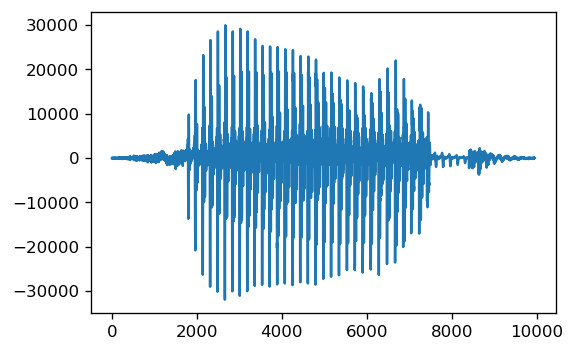

In [4]:
pl.plot(x)

In [5]:
from IPython.display import Audio
Audio(data=x, rate=fs)

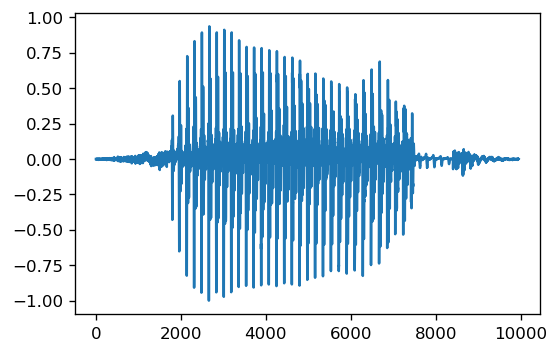

In [6]:
x = np.float32(x)
x /= np.max(np.abs(x))
pl.plot(x)

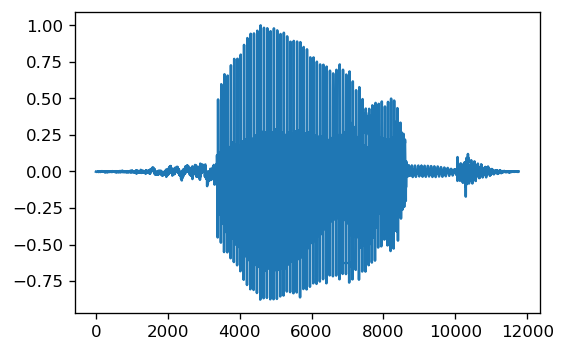

In [7]:
x2 = np.float32(x2)
x2 /= np.max(np.abs(x2))
pl.plot(x2)

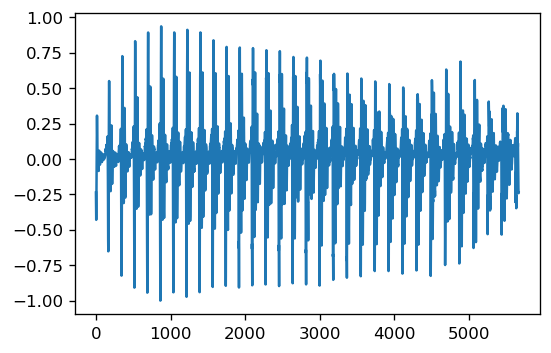

In [8]:
first = np.where(np.abs(x) > 0.2)[0][0]
last = np.where(np.abs(x) > 0.2)[0][-1]

first2 = np.where(np.abs(x2) > 0.2)[0][0]
last2 = np.where(np.abs(x2) > 0.2)[0][-1]

pl.plot(x[first:last])

Text(0, 0.5, 'S (dB)')

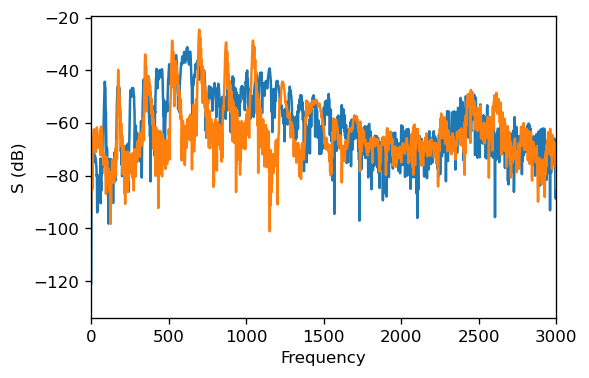

In [10]:
from scipy import signal

f, S = signal.periodogram(x, window='hann', fs=fs)
f2, S2 = signal.periodogram(x2, window='hann', fs=fs)

pl.plot(f, 10*np.log10(S))
pl.plot(f2, 10*np.log10(S2))

pl.xlim([0, 3000])
pl.xlabel('Frequency')
pl.ylabel('S (dB)')

(0.0, 3000.0)

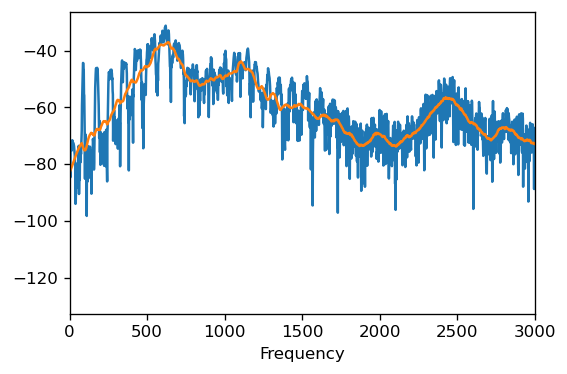

In [14]:
windowlength=99
polyord = 3
Sfilt = signal.savgol_filter(10*np.log10(S), windowlength, polyord)
pl.plot(f, 10*np.log10(S))
pl.plot(f, Sfilt)
pl.xlabel('Frequency')
pl.xlim([0, 3000])

In [16]:
def getSpectralEnv(fname):
    fs, x = wavfile.read(fname)
    x = np.float32(x)
    x /= np.max(np.abs(x))
    f, S = signal.periodogram(x, window='hann', fs=fs)
    windowlength=99
    polyord = 3
    Sfilt = signal.savgol_filter(10*np.log10(S), windowlength, polyord)
    return (Sfilt[f < 3000], f[f < 3000])


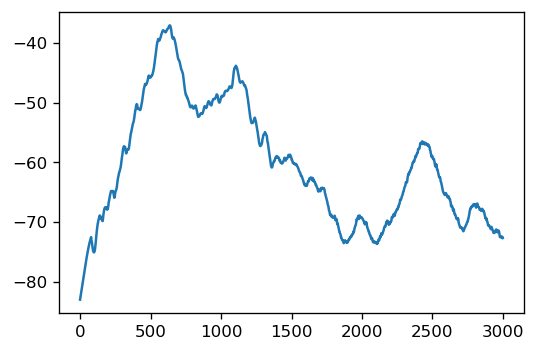

In [18]:
fname = datadir + 'm30aw.wav'
Sfilt, f = getSpectralEnv(fname)
pl.plot(f, Sfilt)


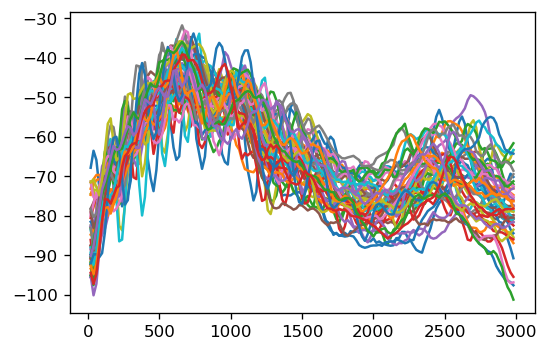

In [29]:
from scipy.interpolate import interp1d
fnew = np.arange(20, 3000, 20)
from os.path import exists

first_time = True
for k in range(50):
    fname = f'm{k+1:02d}aw.wav'
    if exists(datadir + fname):
        Sfilt, f = getSpectralEnv(datadir + fname)
        interpolator = interp1d(f, Sfilt)
        Snew = interpolator(fnew)
        pl.plot(fnew, Snew)
        if first_time:
            X = Snew.copy()
            first_time = False
        else:
            X = np.vstack((X, Snew))
n1 = X.shape[0]

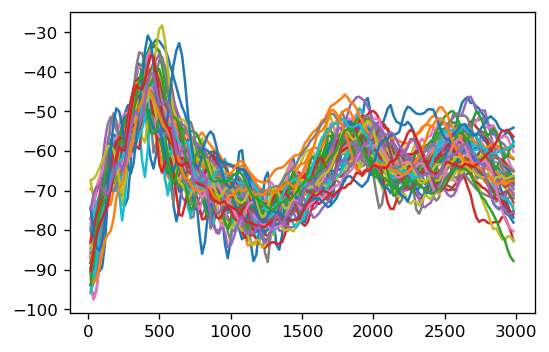

In [30]:
from os.path import exists
for k in range(50):
    fname = f'm{k+1:02d}ih.wav'
    if exists(datadir + fname):
        Sfilt, f = getSpectralEnv(datadir + fname)
        interpolator = interp1d(f, Sfilt)
        Snew = interpolator(fnew)
        pl.plot(fnew, Snew)
        X = np.vstack((X, Snew))
n2 = X.shape[0] - n1

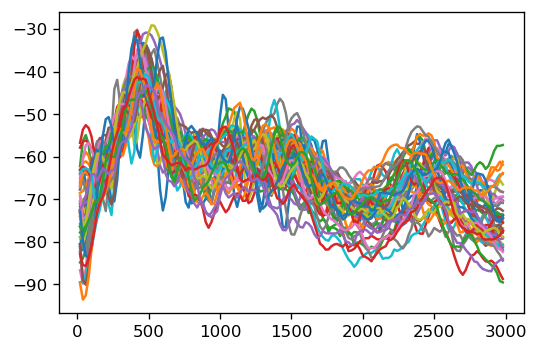

In [41]:
from os.path import exists
for k in range(50):
    fname = f'm{k+1:02d}oo.wav'
    if exists(datadir + fname):
        Sfilt, f = getSpectralEnv(datadir + fname)
        interpolator = interp1d(f, Sfilt)
        Snew = interpolator(fnew)
        pl.plot(fnew, Snew)
        X = np.vstack((X, Snew))
n3 = X.shape[0] - n1 - n2

In [42]:
y = np.zeros(n1+n2+n3)
y[n1:(n1+n2)] = 1
y[(n1+n2):] = 2

In [43]:
X.shape

(135, 149)

In [44]:
y.shape

(135,)

In [57]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pc = PCA(n_components=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [58]:
pc.fit(X_train)

PCA(n_components=10)

In [59]:
X_train_pc = pc.transform(X_train)
X_test_pc = pc.transform(X_test)

In [60]:
X_train_pc.shape

(90, 10)

In [61]:
from sklearn.svm import SVC

model = SVC()

model.fit(X_train_pc, y_train)

y_train_predicted = model.predict(X_train_pc)
acc_train = 100 * (y_train_predicted == y_train).sum() / y_train.shape[0]
print(f'Training accuracy = {acc_train: 0.2f}')

Training accuracy =  100.00


In [62]:
y_test_predicted = model.predict(X_test_pc)
acc_test = 100 * (y_test_predicted == y_test).sum() / y_test.shape[0]
print(f'Testing accuracy = {acc_test: 0.2f}')

Testing accuracy =  100.00
